In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [22]:
transforms = Compose([ToTensor(),
                                Normalize((0.1307,), (0.3081,)),])
data_path = '/workspace/nvflare/FedProx/Data'
test = CIFAR10(root=data_path, transform=transforms, download=True, train=False)

Files already downloaded and verified


In [23]:
test_loader = DataLoader(test, batch_size=4, shuffle=True)

In [24]:
model = SimpleNetwork()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss = nn.CrossEntropyLoss()

In [35]:
test_model_path = "/workspace/nvflare/FedProx/server/run_142/app_server/FL_global_model.pt"

In [36]:
model.load_state_dict(torch.load(test_model_path)['model'])

<All keys matched successfully>

In [37]:
def predict(model, data_loader) : 
    model = model.eval()

    predictions = []

    real_values = [ ]
    with torch.no_grad():
      for i, batch in enumerate(data_loader):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = model(images)
        _,preds = torch.max(out, dim = 1)

        predictions.extend(preds)
        real_values.extend(labels)
    predictions = torch.stack(predictions).cpu()
    real_value = torch.stack(real_values).cpu()
    return predictions , real_value

In [38]:
y_pred,y_test = predict(model, test_loader)

In [39]:
y_pred[:50]

tensor([7, 3, 4, 7, 0, 9, 3, 3, 5, 6, 3, 6, 8, 1, 2, 1, 0, 3, 5, 0, 5, 8, 0, 5,
        9, 8, 6, 7, 8, 5, 4, 6, 3, 6, 4, 9, 7, 0, 2, 7, 3, 0, 2, 4, 7, 0, 5, 3,
        7, 3])

In [40]:
y_test[:50]

tensor([3, 3, 6, 7, 0, 9, 5, 7, 5, 6, 2, 2, 0, 1, 2, 1, 0, 6, 1, 0, 5, 9, 0, 6,
        9, 8, 6, 3, 8, 7, 4, 1, 5, 6, 3, 9, 5, 0, 6, 7, 5, 0, 2, 4, 7, 0, 8, 5,
        5, 3])

In [41]:
report = classification_report(y_test,y_pred,digits=4)

In [42]:
print(report)

              precision    recall  f1-score   support

           0     0.6749    0.5710    0.6186      1000
           1     0.7700    0.6730    0.7182      1000
           2     0.4778    0.4630    0.4703      1000
           3     0.3321    0.4510    0.3825      1000
           4     0.4547    0.5070    0.4794      1000
           5     0.4658    0.3950    0.4275      1000
           6     0.6395    0.6190    0.6291      1000
           7     0.6367    0.5870    0.6108      1000
           8     0.6323    0.7550    0.6882      1000
           9     0.6667    0.6040    0.6338      1000

    accuracy                         0.5625     10000
   macro avg     0.5751    0.5625    0.5659     10000
weighted avg     0.5751    0.5625    0.5659     10000



In [43]:
plt.rcParams.update({'font.size': 10})

<AxesSubplot:>

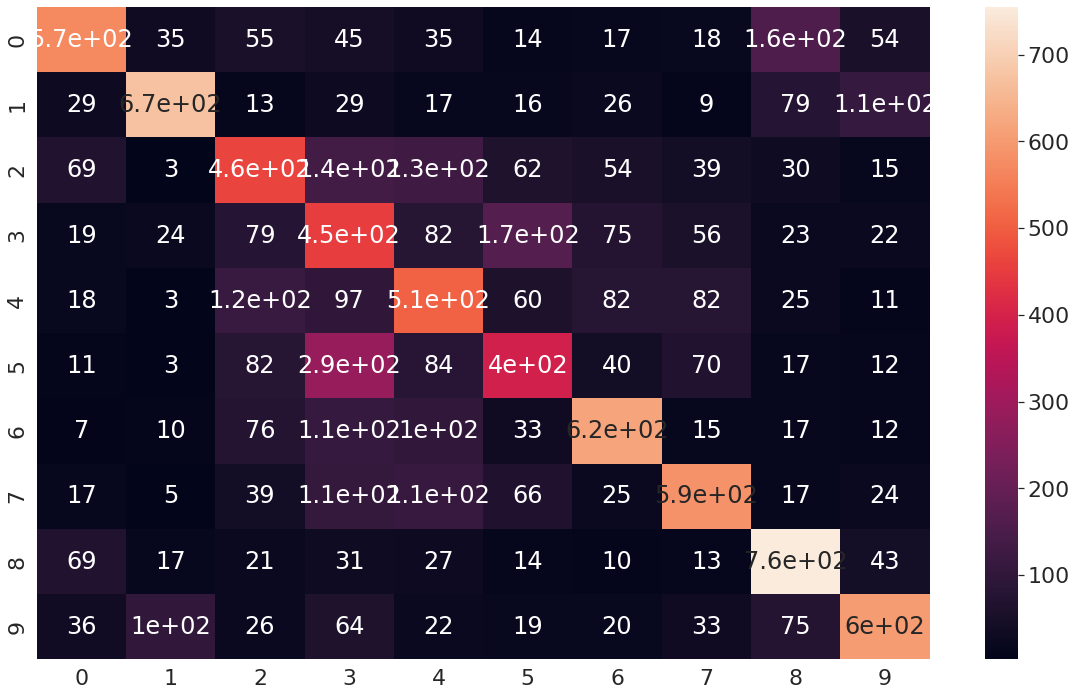

In [44]:
sns.set(font_scale=2.0)
plt.figure(figsize = (20,12))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)